In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Read data files and build array

### Build input tensor 與 data loader

In [39]:
tensorX = torch.FloatTensor(X)
print(tensorX.shape)

torch.Size([174, 4464])


In [40]:
tensorY = torch.FloatTensor(y)
print(tensorY.shape)

torch.Size([174])


In [41]:
dataset = Data.TensorDataset(tensorX, tensorY)

In [42]:
batch_size = 16

In [43]:
dataloader = Data.DataLoader(
    dataset= dataset,     
    batch_size= batch_size,       
    shuffle=True,              
    num_workers=2,             
)

### Define Auto-encoder

Reference: https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder

In [44]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(   
            nn.Linear(4464, 3800),
            nn.ReLU(),
            nn.Linear(3800, 2000),                
            nn.ReLU(),
            nn.Linear(2000, 800), 
            nn.ReLU(),
            nn.Linear(800, 80), 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(80, 800),
            nn.ReLU(),
            nn.Linear(800, 2000),                
            nn.ReLU(),
            nn.Linear(2000, 3800), 
            nn.ReLU(),
            nn.Linear(3800, 4464), 
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [45]:
learning_rate = 1e-3

In [46]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

### Train NN

In [47]:
num_epochs = 3

In [48]:
for epoch in range(num_epochs):
    model.train().to(device)
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        X = data[0]
        X = Variable(X).to(device)
        output = model(X)
        loss = criterion(output, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, float(loss.data)))

epoch [1/3], loss:0.0579
epoch [2/3], loss:0.0242
epoch [3/3], loss:0.0568


In [ ]:
torch.save(model.state_dict(), './NNWeights.AE')

# Visualize input and output generated by AE

In [49]:
for batch_idx, data in enumerate(dataloader):
    break

In [50]:
YBatch = data[1]
y = YBatch[0].data.cpu()

In [51]:
int(YBatch[0])

56

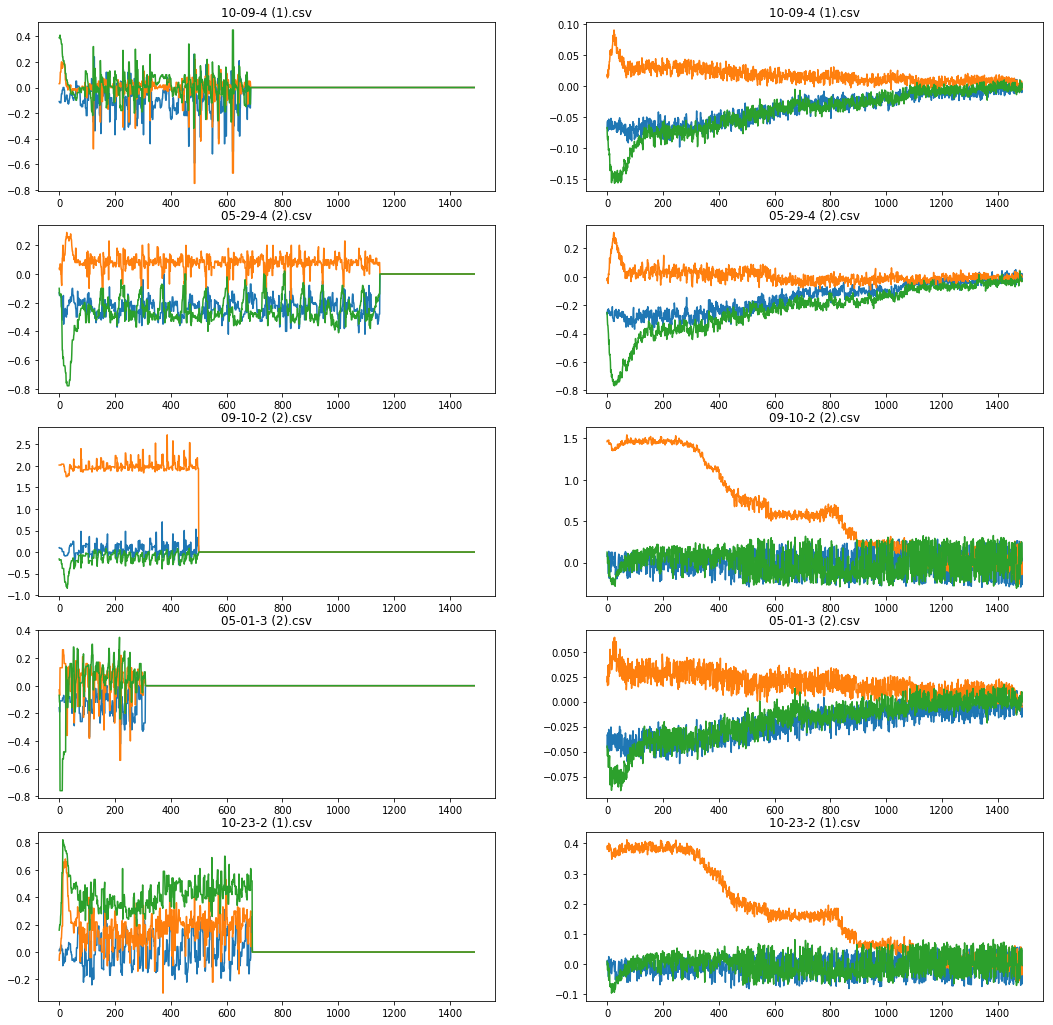

In [52]:
fig = plt.figure(figsize=(18, 18))
sub_fig_index = 1
for batch_idx, data in enumerate(dataloader):
    # get a batch of data
    XBatch = data[0]
    YBatch = data[1]
    XBatch = Variable(XBatch).to(device)
    output = model(XBatch)
   
    # for each data in the batch
    for i in range(XBatch.size(0)): 
        gpu_tensor = XBatch[i].data
        cpu_tensor = gpu_tensor.cpu()
        nparray = cpu_tensor.numpy().reshape(CUT, 3)
        
        y = int(YBatch[i].data.cpu())
        
        fig.add_subplot(5, 2, sub_fig_index) 
        sub_fig_index +=1
        plt.plot(nparray)
        plt.title(_FNameLst_[y-1])

        gpu_tensor = output[i].data
        cpu_tensor = gpu_tensor.cpu()
        nparray = cpu_tensor.numpy().reshape(CUT, 3)
        fig.add_subplot(5, 2, sub_fig_index)
        plt.plot(nparray)
        plt.title(_FNameLst_[y-1])
        
        sub_fig_index +=1
        if(sub_fig_index == 11):
            break
    if(sub_fig_index == 11):
        break
plt.show()

### Save feature vectors

In [66]:
lst=[]
for batch_idx, data in enumerate(dataloader):
    XBatch = data[0]
    YBatch = data[1]
    XBatch = Variable(XBatch).to(device)
    output = model.encoder(XBatch)
    
    # for each data in the batch
    for i in range(XBatch.size(0)): 
        y = int(YBatch[i].data.cpu())
        fname = _FNameLst_[y-1]
        
        gpu_tensor = output[i].data
        cpu_tensor = gpu_tensor.cpu()
        lst1 = [fname] + cpu_tensor.tolist()
        lst.append(lst1)
        
# lst = [[fname1, 80 features of fname1], [fname2, 80 features of fname2], ...]

In [68]:
### save file_name, feature vectors
headerLst = ['fname']
for i in range(1, 81):
    headerLst.append('f' + str(i))
df = pd.DataFrame(lst, columns = headerLst)

In [70]:
df.to_csv("features.csv", index=False)

### Send features to t-SNE or use Orange to read the feature file

In [78]:
# featuresLst = [[80 features of fname1], [80 features of fname2], ...]
# fnameLst = [fname1, fname2, ...]
featuresLst=[]
fnameLst = []
for batch_idx, data in enumerate(dataloader):
    XBatch = data[0]
    YBatch = data[1]
    XBatch = Variable(XBatch).to(device)
    output = model.encoder(XBatch)
    
    # for each data in the batch
    for i in range(XBatch.size(0)): 
        y = int(YBatch[i].data.cpu())
        fname = _FNameLst_[y-1]
        fnameLst.append(fname)
        
        gpu_tensor = output[i].data
        cpu_tensor = gpu_tensor.cpu()
        lst = cpu_tensor.tolist()
        featuresLst.append(lst)

In [79]:
array = np.array(featuresLst)
array.shape

(174, 80)

In [80]:
from sklearn.manifold import TSNE

In [81]:
tsne = TSNE(perplexity=10, n_components=2, init='random', n_iter=5000)
result = tsne.fit_transform(array)

In [82]:
result.shape

(174, 2)

In [83]:
tSNEXarray = result[:, 0]
tSNEYarray = result[:, 1]

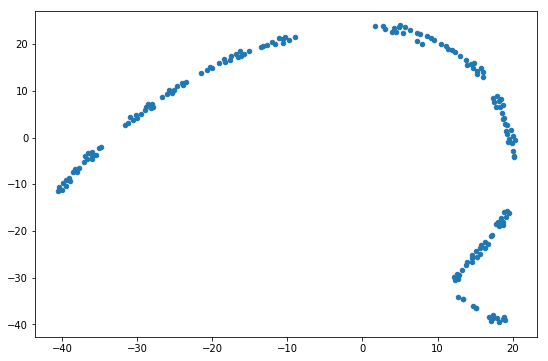

In [84]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(tSNEXarray, tSNEYarray, s=20)
plt.show()

In [89]:
# save to file
lst = []
headerLst = ['fname', 'x', 'y']
Xlst = tSNEXarray.tolist()
Ylst = tSNEYarray.tolist()
for i in range(len(Xlst)):
    tmp = [fnameLst[i], Xlst[i], Ylst[i]]
    lst.append(tmp)
df = pd.DataFrame(lst, columns = headerLst)
df.to_csv("tSNEResults.csv", index=False)